# Stock Price Forcasting Using Tensorflow - V2

In [74]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## Micellaneous Functions

In [75]:
def drop_columns(hist):
    return hist.drop(columns=['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'])

def set_size(num, df):
    return df.shape[0]-num

## Collecting the data

In [76]:
data = yf.Ticker('MSFT')
df = drop_columns(data.history(start='2010-01-01'))
n = len(df)
df

,Close
Date,
2010-01-04,24.17
2010-01-05,24.18
2010-01-06,24.03
2010-01-07,23.78
2010-01-08,23.94
...,...
2020-09-21,202.54
2020-09-22,207.42
2020-09-23,200.59


## Splitting the data

In [77]:
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

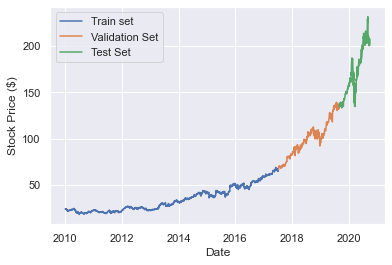

In [78]:
plt.plot(train_df['Close'])
plt.plot(val_df['Close'])
plt.plot(test_df['Close'])
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend(['Train set', 'Validation Set', 'Test Set'])
plt.show()

## Pre-processing the data and creating a baseline with simple RNN

In [79]:
import tensorflow as tf

features = ['Close']

np.random.seed(42)
tf.random.set_seed(42)

# Might need to create a TensorFlow dataset in order to get it to behave properly
train_df.index = range(1, len(train_df)+1)

training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(train_df[features].values, tf.float64),
            tf.cast(train_df.index.values, tf.int8)
        )
    )
)

val_df.index = range(1, len(val_df)+1) 
val_df.index += len(train_df)

validation_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(val_df[features].values, tf.float64),
            tf.cast(val_df.index.values, tf.int8)
        )
    )
)

training_dataset, validation_dataset

(<TensorSliceDataset shapes: ((1,), ()), types: (tf.float64, tf.int8)>,
 <TensorSliceDataset shapes: ((1,), ()), types: (tf.float64, tf.int8)>)

In [140]:
def create_time_series(n_steps):
    n_len = n_steps
    t = np.linspace(1, n_len, n_len)
    return t

t = create_time_series(len(train_df))

y_train = train_df.to_numpy()
# y_train = np.expand_dims(y_train, axis=1)
x_train = np.expand_dims(t, axis=1)
x_train = np.expand_dims(x_train, axis=1)
x_train.shape, y_train.shape

((1891, 1, 1), (1891, 1))

In [132]:
y_val = val_df.to_numpy()
y_val = np.expand_dims(y_val, axis=1)
y_val.shape

(540, 1, 1)

In [142]:
# Creating simple RNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=x_train.shape)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(x_train, epochs=20)
history

ValueError: Input 0 of layer simple_rnn_30 is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: [None, 1891, 1, 1]